## Image Retrieval with Azure AI Search

Requirements:
1. Azure AI Search - to contain the image embeddings
2. Azure Computer Vision - to compute the image and user query (image or text) embeddings
3. Azure Storage - to store the raw images

Steps:
1. Store images in Azure Storage 
2. Get access to images in Azure Storage
3. Create Search index in Azure AI Search
4. Generate embeddings and dense captions for images using Azure AI Vision
5. Store embeddings and other metadata to Azure AI Search
6. Perform a Vector Search in Azure AI Search

## Load Azure Configuration

In [2]:
import os

azure_computer_vision_endpoint = os.environ["AZURE_COMPUTER_VISION_ENDPOINT"]
azure_computer_vision_key = os.environ["AZURE_COMPUTER_VISION_KEY"]

azure_storage_connection_string = os.getenv("AZURE_STORAGE_CONNECTION_STRING")

azure_search_service_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
azure_search_service_admin_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")
azure_search_service_index_name = "az-image-index-001"
azure_search_service_embedding_size=1024


## Get files from Azure Storage and Store in a collection

In [3]:
from azure.storage.blob import BlobServiceClient

# Initialize the BlobServiceClient with the connection string
blob_service_client = BlobServiceClient.from_connection_string(azure_storage_connection_string)

# Get the container client
container_client = blob_service_client.get_container_client("images")

# List blobs in the container and store their URLs, names, and IDs in a collection
blobs_collection = []

idx = 0
try:
    blobs_list = container_client.list_blobs()
    for blob in blobs_list:
        idx += 1
        blob_url = f"{container_client.url}/{blob.name}"
        blobs_collection.append({"id": str(idx), "imageName": blob.name, "imageUrl": blob_url})
    print("Access to the blob storage was granted.")
except Exception as e:
    print(f"Failed to access the blob storage: {e}")

# Print the collection
print("Blobs collection:")
for blob in blobs_collection:
    print(blob)

Access to the blob storage was granted.
Blobs collection:
{'id': '1', 'imageName': 'analyze_image.jpg', 'imageUrl': 'https://ziggystorage01.blob.core.windows.net/images/analyze_image.jpg'}
{'id': '2', 'imageName': 'bicycle1.jpeg', 'imageUrl': 'https://ziggystorage01.blob.core.windows.net/images/bicycle1.jpeg'}
{'id': '3', 'imageName': 'bicycle10.jpeg', 'imageUrl': 'https://ziggystorage01.blob.core.windows.net/images/bicycle10.jpeg'}
{'id': '4', 'imageName': 'bicycle2.jpeg', 'imageUrl': 'https://ziggystorage01.blob.core.windows.net/images/bicycle2.jpeg'}
{'id': '5', 'imageName': 'bicycle3.jpeg', 'imageUrl': 'https://ziggystorage01.blob.core.windows.net/images/bicycle3.jpeg'}
{'id': '6', 'imageName': 'bicycle4.jpeg', 'imageUrl': 'https://ziggystorage01.blob.core.windows.net/images/bicycle4.jpeg'}
{'id': '7', 'imageName': 'bicycle5.jpeg', 'imageUrl': 'https://ziggystorage01.blob.core.windows.net/images/bicycle5.jpeg'}
{'id': '8', 'imageName': 'bicycle6.jpeg', 'imageUrl': 'https://ziggysto

## Generate Dense Captions for each Image

In [4]:
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

# Create an Image Analysis client
client = ImageAnalysisClient(
    endpoint=azure_computer_vision_endpoint,
    credential=AzureKeyCredential(azure_computer_vision_key)
)

# Get dense captions for each image in the collection and add them to the collection
for blob in blobs_collection:

    # Get the dense captions for the image. This will be a synchronously (blocking) call.
    response = client.analyze_from_url(
        image_url=blob["imageUrl"],
        visual_features=[VisualFeatures.DENSE_CAPTIONS],
        gender_neutral_caption=True,  # Optional (default is False)
    )

    # Collect all dense captions' text and combine them with a comma separator
    dense_captions_text = ", ".join([item['text'] for item in response.dense_captions['values']])

    # Add the embeddings to the collection
    if response:
        blob["imageDenseCaptions"] = dense_captions_text
    else:
        blob["imageDenseCaptions"] = None

# Print the collection
print("Blobs collection:")
for blob in blobs_collection:
    print(blob)


Blobs collection:
{'id': '1', 'imageName': 'analyze_image.jpg', 'imageUrl': 'https://ziggystorage01.blob.core.windows.net/images/analyze_image.jpg', 'imageDenseCaptions': "a person looking at a laptop, a group of women sitting at a table looking at a laptop, a person's hands on a laptop, blur a blurry picture of a window, a close-up of a person's eyes, a person in glasses looking at a laptop, a blurry image of a tree, blur a blurry image of a computer screen, a person smiling at something, a close-up of a person wearing glasses"}
{'id': '2', 'imageName': 'bicycle1.jpeg', 'imageUrl': 'https://ziggystorage01.blob.core.windows.net/images/bicycle1.jpeg', 'imageDenseCaptions': 'a black and red bicycle, a black and red bicycle, a close up of a bicycle tire, a close up of a bicycle gear, a close up of a bicycle wheel, a close up of a bicycle, close-up of a bicycle seat, a close up of a wheel, a close up of a handlebar, a black machine with a red button'}
{'id': '3', 'imageName': 'bicycle10.jp

## Vectorize Image API

In [5]:
import requests

# Function to vectorize an image
def vectorize_image(image_source, is_url=True):
    # API URL
    url = f"{azure_computer_vision_endpoint}/computervision/retrieval:vectorizeImage?api-version=2024-02-01&model-version=2023-04-15"

    headers = {
        "Ocp-Apim-Subscription-Key": azure_computer_vision_key
    }

    try:
        if is_url:
            # Set headers for URL
            headers["Content-Type"] = "application/json"
            data = {
                "url": image_source
            }
            # Make the request
            response = requests.post(url, headers=headers, json=data)
        else:
            # Read the image file
            with open(image_source, "rb") as image_file:
                image_data = image_file.read()

            # Set headers for image file
            headers["Content-Type"] = "application/octet-stream"
            # Make the request
            response = requests.post(url, headers=headers, data=image_data)

        response.raise_for_status()  # Raise an exception for HTTP errors

        # Return the response
        return response.json()

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None

## Get Embeddings for each Image and Save Collection to a file

In [6]:

# Vectorize each image in the collection and add the embeddings to the collection
for blob in blobs_collection:
    # Vectorize the image
    response = vectorize_image(blob["imageUrl"], is_url=True)

    # Add the embeddings to the collection
    if response:
        blob["imageVector"] = response["vector"]
    else:
        blob["imageVector"] = None

# save the blob collection to a file
import json
# Save the blob collection to a file
output_file = "blobs_collection.json"
with open(output_file, "w") as file:
    json.dump(blobs_collection, file, indent=4)

print(f"Blobs collection saved to {output_file}")


Blobs collection saved to blobs_collection.json


## Create an Azure AI Search Index

In [7]:
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SearchField,
    SimpleField,
    SearchableField,
    SearchFieldDataType,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    SearchIndex
)

# Get credential from Azure AI Search Admin key
credential = AzureKeyCredential(azure_search_service_admin_key)

# Create a search index
index_client = SearchIndexClient(
  endpoint=azure_search_service_endpoint, 
  credential=credential)

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="imageName", type=SearchFieldDataType.String),
    SearchableField(name="imageUrl", type=SearchFieldDataType.String),
    SearchableField(name="imageDenseCaptions", type=SearchFieldDataType.String),
    SearchField(name="imageVector", 
                type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, 
                vector_search_dimensions=azure_search_service_embedding_size, 
                vector_search_profile_name="myHnswProfile"),
]

# Configure the vector search configuration  
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(name="myHnsw")
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswProfile",
            algorithm_configuration_name="myHnsw"
        )
    ] 
)

# Create the search index with the semantic settings
index = SearchIndex(name=azure_search_service_index_name, 
                    fields=fields,
                    vector_search=vector_search)

result = index_client.create_or_update_index(index)
print(f' {result.name} created')

 az-image-index-001 created


## Upload data into Search Index

In [8]:
import json
from azure.search.documents import SearchIndexingBufferedSender

# Load the JSON file
file_path = 'blobs_collection.json'
with open(file_path, 'r') as file:
    documents = json.load(file)

# Use SearchIndexingBufferedSender to upload the documents in batches optimized for indexing
with SearchIndexingBufferedSender(
    endpoint=azure_search_service_endpoint,
    index_name=azure_search_service_index_name,
    credential=credential,
) as batch_client:
    # Add upload actions for all documents
    batch_client.upload_documents(documents)

print(f"Uploaded {len(documents)} documents in total")

Uploaded 62 documents in total


## Vectorize Text API

In [9]:
import requests

def vectorize_text(text):
    
    # API URL
    url = f"{azure_computer_vision_endpoint}/computervision/retrieval:vectorizeText?api-version=2024-02-01&model-version=2023-04-15"

    # Set headers
    headers = {
        "Content-Type": "application/json",
        "Ocp-Apim-Subscription-Key": azure_computer_vision_key
    }

    # Set the data payload
    data = {
        "text": text
    }

    try:
        # Make the request
        response = requests.post(url, headers=headers, json=data)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Return the JSON response
        return response.json()

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None


# Perform a Text Search in Azure AI Search

In [11]:
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizedQuery
from azure.core.credentials import AzureKeyCredential
from IPython.display import Image, display

# Get credential from Azure AI Search Admin key
credential = AzureKeyCredential(azure_search_service_admin_key)
search_client = SearchClient(endpoint=azure_search_service_endpoint, 
                             credential=credential, 
                             index_name=azure_search_service_index_name)

# Get the vector of the query
query = "people working with a laptop"
vectorized_text = vectorize_text(query)
vector = vectorized_text["vector"]

# display user input
print(f"User Input: {query}")
print("************************************")

# Create the VectorizedQuery instance
vector_query = VectorizedQuery(
    vector=vector, 
    k_nearest_neighbors=5, 
    fields="imageVector"
)

results = search_client.search(  
    search_text=None,  
    vector_queries=[vector_query],
    select=["imageName", "imageUrl", "imageDenseCaptions"],
    top=5
)

# Process and display the results
print("Search Results: ")
for result in results:
    print(f"Score: {result['@search.score']}")
    image_name = result['imageName']
    image_url = result['imageUrl']
    image_dense_captions = result['imageDenseCaptions']
    print(f"Image Name: {image_name}, Image URL: {image_url}")
    print(f"Dense Captions: {image_dense_captions}")
    display(Image(url=image_url))

User Input: people working with a laptop
************************************
Search Results: 
Score: 0.62159467
Image Name: analyze_image.jpg, Image URL: https://ziggystorage01.blob.core.windows.net/images/analyze_image.jpg
Dense Captions: a person looking at a laptop, a group of women sitting at a table looking at a laptop, a person's hands on a laptop, blur a blurry picture of a window, a close-up of a person's eyes, a person in glasses looking at a laptop, a blurry image of a tree, blur a blurry image of a computer screen, a person smiling at something, a close-up of a person wearing glasses


Score: 0.61380297
Image Name: group_2.jpeg, Image URL: https://ziggystorage01.blob.core.windows.net/images/group_2.jpeg
Dense Captions: a couple of women looking at a laptop, a person looking at a laptop, a couple of women looking at a laptop, a close-up of a person smiling, blur a blurry picture of a book


Score: 0.61146015
Image Name: person_b1.jpeg, Image URL: https://ziggystorage01.blob.core.windows.net/images/person_b1.jpeg
Dense Captions: a person with short curly hair and a nose ring talking to a person on a laptop, a person smiling at a computer screen, a close up of a white surface


Score: 0.60750765
Image Name: group_1.jpeg, Image URL: https://ziggystorage01.blob.core.windows.net/images/group_1.jpeg
Dense Captions: a person looking at another person, a person smiling with her hand on her chin, a person pointing at a windmill, a close-up of a windmill


Score: 0.60390174
Image Name: person_a2.jpeg, Image URL: https://ziggystorage01.blob.core.windows.net/images/person_a2.jpeg
Dense Captions: a person pointing at a small windmill, a person pointing at a model windmill, a person holding a small windmill, a blurry image of a person sitting in a chair, a blurry image of a person's head


# Perform a search using an Image in Azure AI Search

User Input: testimage.jpeg


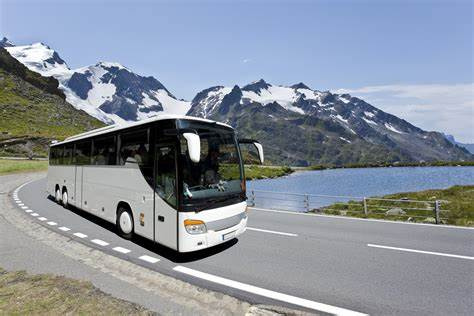

************************************
Search Results: 
Score: 0.8889207
Image Name: bus9.jpeg, Image URL: https://ziggystorage01.blob.core.windows.net/images/bus9.jpeg


Score: 0.87775326
Image Name: bus6.jpeg, Image URL: https://ziggystorage01.blob.core.windows.net/images/bus6.jpeg


Score: 0.866144
Image Name: bus7.jpeg, Image URL: https://ziggystorage01.blob.core.windows.net/images/bus7.jpeg


In [13]:
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizedQuery
from azure.core.credentials import AzureKeyCredential
from IPython.display import Image, display

# Get credential from Azure AI Search Admin key
credential = AzureKeyCredential(azure_search_service_admin_key)
search_client = SearchClient(endpoint=azure_search_service_endpoint, 
                             credential=credential, 
                             index_name=azure_search_service_index_name)

# Get the vector of the query
query = "testimage.jpeg"
vectorized_image = vectorize_image(query, is_url=False)
vector = vectorized_image["vector"]

# display user input
print(f"User Input: {query}")
display(Image(filename=query))
print("************************************")

# Create the VectorizedQuery instance
vector_query = VectorizedQuery(
    vector=vector, 
    k_nearest_neighbors=5, 
    fields="imageVector"
)

# Perform the search
results = search_client.search(
    search_text=None,  
    vector_queries=[vector_query],  # Include the vector query here
    select=["imageName", "imageUrl"],
    top=3
)

# Process and display the results
print("Search Results: ")
for result in results:
    print(f"Score: {result['@search.score']}")
    image_name = result['imageName']
    image_url = result['imageUrl']
    print(f"Image Name: {image_name}, Image URL: {image_url}")
    display(Image(url=image_url))